In [1]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam
from backtester.swarms import SwarmManager, SwarmRanker
from backtester.positionsizing import PositionSizingBase
import pandas as pd
import numpy as np
import scipy

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


## Script settings

In [3]:
# File name of exo strategy
EXO_File = 'strategy_880131'


#
# Costs settings
#
costs_options = 3.0 # 3$ per side per option contract
costs_futures = 3.0 # 3$ per side per futures contract



#
# Swarm settings
#

# number of strategies to pick  from the swarm
NSwarm_Members = 5

#
# Swarm generation parameters
#  MA Cross periods and Trailing stop size
STRATEGY_PARAMS = [
            #OptParam(name, default_value, min_value, max_value, step)
            OptParam('SlowMAPeriod', 20, 10, 30, 2),
            OptParam('FastMAPeriod', 2, 2, 20, 1),
            OptParam('MedianPeriod', 5, 5, 20, 3)
        ]



#
# Swingpoint global filter settings
#

# As a multiplier of volatility
up_factor = 3.0
down_factor = 10.0


## Exo data

In [4]:
strategyname_global = EXO_File
d, info = matlab.loaddata('../mat/'+strategyname_global+'.mat')

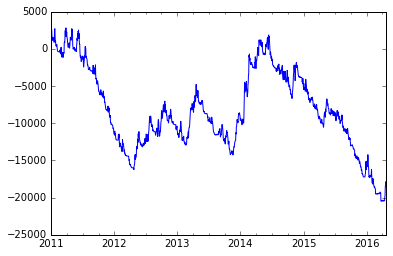

In [5]:
d.exo.plot()


In [6]:
info

{'legs': 3,
 'name': 'CallSpread',
 'pcf': array([0, 0, 2], dtype=uint8),
 'pcfqty': array([ 1, -1,  0], dtype=int16),
 'tickincrement': 0.001,
 'tickvalue': 10,
 'underlying': 'NGE'}

# Getting original swingpoint levels from mat file


In [7]:
from scipy.io import loadmat, savemat
mat = loadmat('../mat/'+strategyname_global+'.mat')

In [8]:
print(mat['optStr'].dtype.names)

('cfgName', 'strategyID', 'instrumentSymbol', 'instrumentId', 'tickIncrement', 'secondaryTickIncrement', 'secondaryTickIncrementRule', 'tickValue', 'margin', 'nDecimalPlaces', 'formattingStr', 'dayOHLC', 'sphIndicator', 'splIndicator', 'sphLevel', 'splLevel', 'sphVolume', 'splVolume', 'optionStrikeIncrement', 'customdayboundarytime', 'decisionOffsetMinutes', 'decisionTime', 'legs', 'pcf', 'cfgContracts', 'cfgMonthsB4Exp', 'cfgRollDaysB4Exp', 'cfgOptStrikePriceInc', 'longContracts', 'shortContracts', 'instrumentDecPoints', 'commisionPerContract', 'marginPerContract', 'fEnabled', 'iterate', 'maxContracts', 'minContracts', 'incContracts', 'nDbContracts', 'dbContracts', 'tmlOptimalizationDates', 'tmlOptimalizationDatesIdx', 'tmlOptimalParameters', 'tmlPeriodPerformance', 'nDbOptionExpiry', 'dbOptionExpiry', 'activeContract', 'activeContractId', 'strikeLevel', 'seriesDates', 'dataSeries', 'dataSeriesPD', 'decisionSeries', 'adjustedDecisionSeries', 'adjustedSeries', 'movingAverageLead', 'mov

In [96]:
mat['optStr']['margin'][0][0][0][0]

2310

In [64]:
g_price =  pd.Series(mat['optStr']['entrySignalingSeries'][0][0][3], index=d.exo.index)

g_sphLevel = pd.Series(mat['optStr']['sphLevel'][0][0][0], index=d.exo.index)
g_splLevel = pd.Series(mat['optStr']['splLevel'][0][0][0], index=d.exo.index)

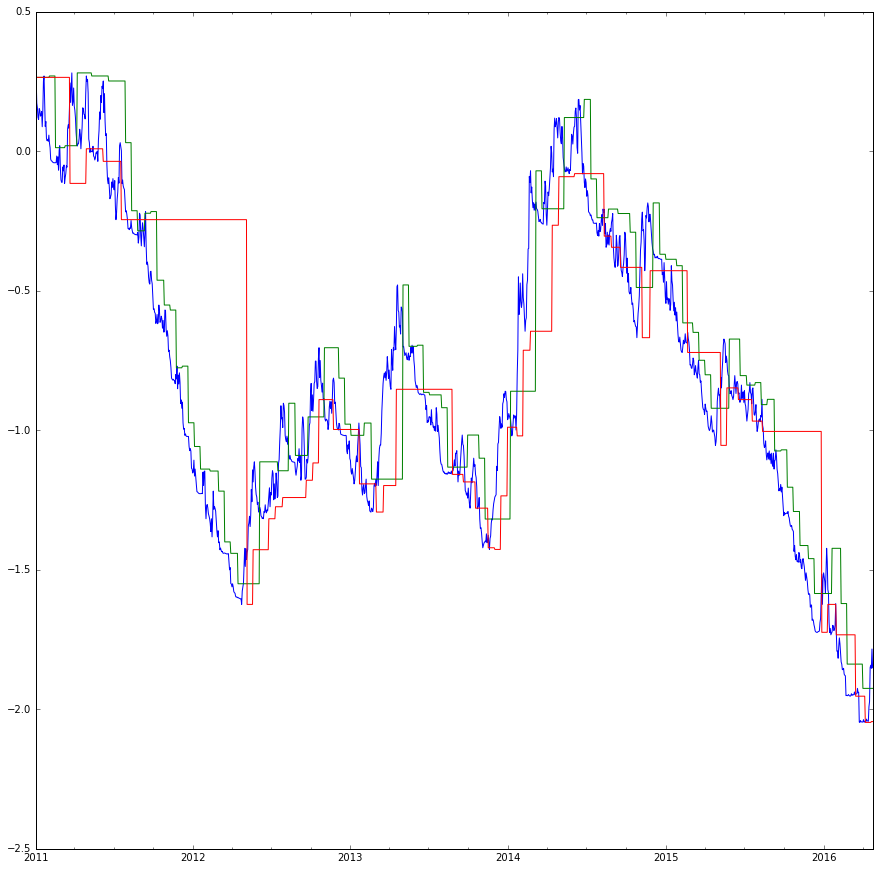

In [65]:
figsize(15, 15)
g_price.plot()
g_sphLevel.plot()
g_splLevel.plot()

In [85]:
sphThreshold = 8 # ????
splThreshold = 8 # ????


signalArray = mat['optStr']['entrySignalingSeries'][0][0]
volumeArray =  mat['optStr']['volumeSeries'][0][0][0]

OPEN  = 0; HIGH  = 1; LOW   = 2;  CLOSE = 3;

if len(signalArray) == 1:
    OPEN  = HIGH  = LOW = CLOSE = 0
    
currentHigh  = -np.inf #intmin('int32');
currentLow   = np.inf #intmax('int32');

currentHVol  = 0
currentLVol  = 0
sphDays      = 0
splDays      = 0
sphStart     = 1
splStart     = 1
sphMaxDay    = 0
splMinDay    = 0
prevHigh     = signalArray[HIGH][0]
prevLow      = signalArray[LOW][0]
prevHVol     = volumeArray[0]
prevLVol     = volumeArray[0]


nDays        = len(signalArray[CLOSE])

sphIndicator = np.zeros(nDays)
splIndicator = np.zeros(nDays)

sphLevel = np.zeros(nDays)
splLevel = np.zeros(nDays)

sphVolume = np.zeros(nDays)
splVolume = np.zeros(nDays)

for dday in range(nDays):
    
    if signalArray[HIGH][dday] > currentHigh:
        currentHigh = signalArray[HIGH][dday]
        currentHVol = volumeArray[dday]
        sphMaxDay   = dday;
        sphDays     = 0
    else:
        sphDays = sphDays+1;
    
    if signalArray[LOW][dday] < currentLow:
        currentLow = signalArray[LOW][dday]
        currentLVol = volumeArray[dday]
        splMinDay  = dday
        splDays    = 0
    else:
        splDays = splDays+1;
        
        
            
    if sphDays > sphThreshold:
        sphLevel[dday] = currentHigh;
        sphIndicator[dday] = 1;
        sphVolume[dday] = currentHVol;
        
        for dd in range(sphStart, dday): #?? or dday-1
            sphLevel[dd] = prevHigh
            sphVolume[dd]= prevHVol
        
        prevHigh = currentHigh
        prevHVol = currentHVol
        sphStart = dday
        sphDays = 0    
        currentHigh = -np.inf #intmin('int32');

    elif dday > 1:
        sphVolume[dday] = sphVolume[dday-1]
    elif dday == 1:
        sphVolume[dday] = volumeArray[dday]
        
        
        
        
    if splDays > splThreshold:
        splLevel[dday] = currentLow;
        splIndicator[dday] = 1;
        splVolume[dday] = currentLVol;
        
        for dd in range(splStart, dday):  #??? or dday-1 
            splLevel[dd] = prevLow
            splVolume[dd] = prevLVol

        prevLow = currentLow
        prevLVol = currentLVol
        splStart = dday
        splDays = 0
        currentLow =  np.inf #intmax('int32');
    elif dday > 1:
        splVolume[dday] = splVolume[dday-1]
    elif dday == 1:
        splVolume[dday] = volumeArray[dday]

    # fill to the end
    for dd in range(sphStart, nDays):
        sphLevel[dd] = prevHigh;
        sphVolume[dd] = prevHVol;

    for dd in range(splStart, nDays):
        splLevel[dd] = prevLow;
        splVolume[dd] = prevLVol;


In [86]:
sphLevel = pd.Series(sphLevel, index=d.exo.index)
splLevel = pd.Series(splLevel, index=d.exo.index)

## Checkin SphLevel Equality (sphThreshold = 8)


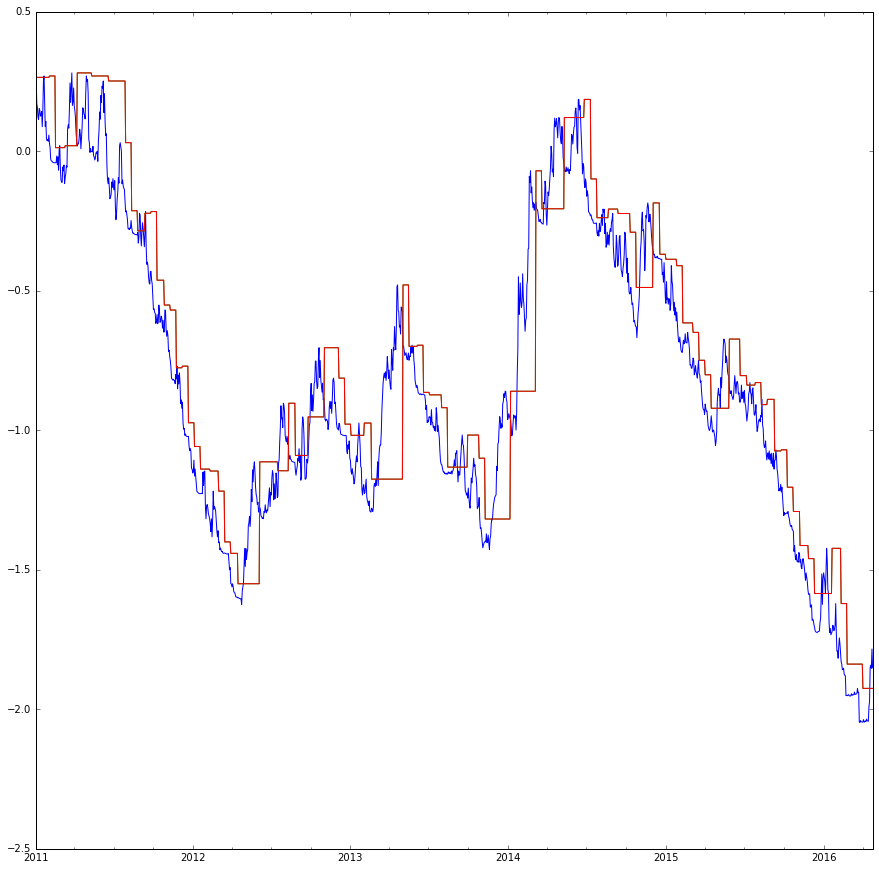

In [87]:
figsize(15, 15)
g_price.plot()
g_sphLevel.plot()
sphLevel.plot()

## Checkin SplLevel equality (splThreshold = 8)

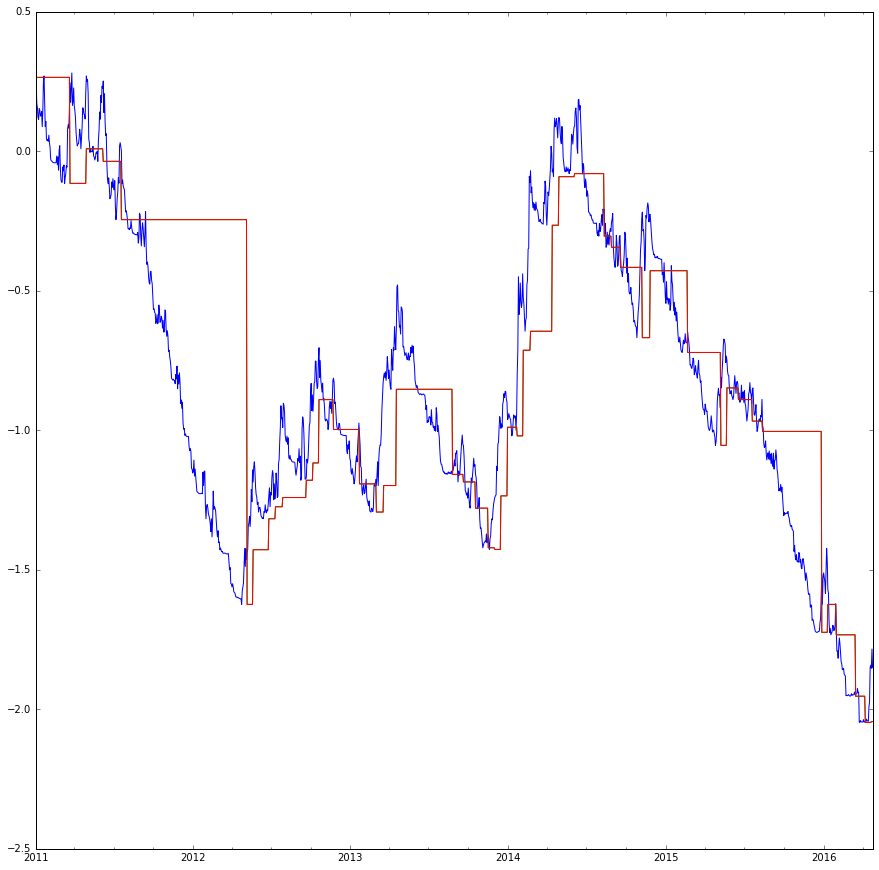

In [91]:
figsize(15, 15)
g_price.plot()
g_splLevel.plot()
splLevel.plot()